## A/B Testing Marketing Promotions

#### Which promotion was the most effective?

Scenario:

A fast food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks

The description of the data set: Our data set consists of 548 entries including:

- MarketId: an inhouse tag used to describe market types, we won't be using it

- AgeOfStores: Age of store in years (1–28). The mean age of a store is 8.5 years.

- LocationID: Unique identifier for store location. Each location is identified by a number. The total number of stores is 137.

- Promotion: One of three promotions that were tested (1, 2, 3). We don’t really know the specifics of each promotion.

- Sales in Thousands: Sales amount for a specific LocationID, Promotion and week. The mean amount of sales are 53.5 thousand dollars.

- Market size: there are three types of market size: small, medium and large.

- Week: One of four weeks when the promotions were run (1–4).

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats

from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
df=pd.read_csv(r"WA_Fn-UseC_-Marketing-Campaign-Eff-UseC_-FastF.csv")

In [6]:
df.loc[df["LocationID"]==6].sort_values(by='LocationID').head(20)

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
20,1,Medium,6,10,3,1,32.90
21,1,Medium,6,10,3,2,22.18
22,1,Medium,6,10,3,3,42.98
23,1,Medium,6,10,3,4,26.68


In [7]:
df.shape

(548, 7)

In [8]:
import pandas_profiling as pp
pp.ProfileReport(df)

In [9]:
df.isnull().sum()

MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64

In [10]:
df.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


# EDA and Visualizations

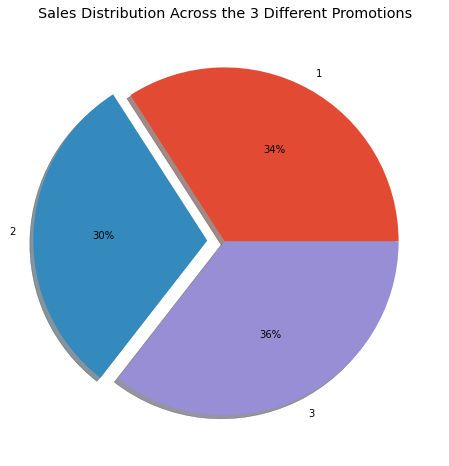

In [11]:
plt.style.use('ggplot')
ax = df.groupby('Promotion').sum()['SalesInThousands'].plot.pie(figsize=(8,8),
                                                                autopct='%1.0f%%',
                                                                shadow=True,
                                                                explode = (0, 0.1, 0))
ax.set_ylabel('')
ax.set_title('Sales Distribution Across the 3 Different Promotions')

plt.show()

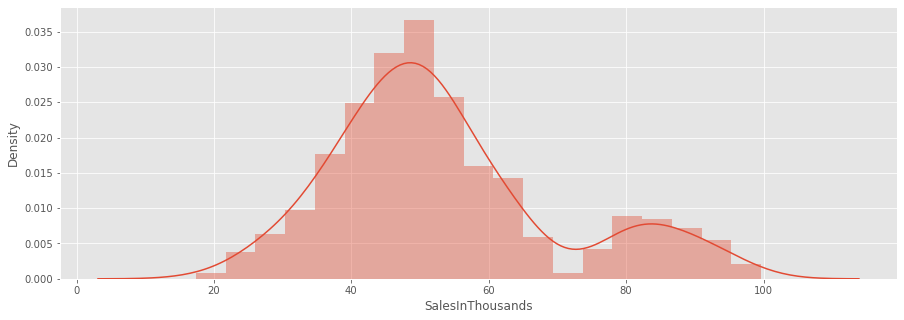

In [12]:
plt.figure(figsize=(15,5))
sns.distplot(df['SalesInThousands']);

**We have a bimodal distribution**

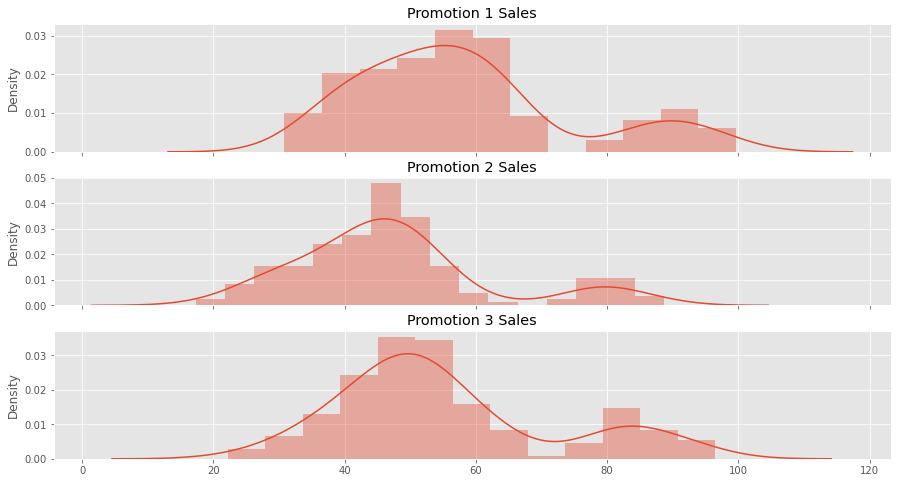

In [13]:
fig,ax=plt.subplots(3,1,figsize=(15,8),sharex=True)

for i in [1,2,3]:
    sns.distplot(df.loc[df['Promotion']==i,'SalesInThousands'],ax=ax[i-1])
    ax[i-1].set_title('Promotion {} Sales'.format(i))
    ax[i-1].set_xlabel ("")

**T-test requires normality but here we have a bimodal distribution, so will split into <=65 & >65 groups**

In [14]:
for i in [1,2,3]:
    print("Count of obs with >65 SALES promo_{}: {}".format(i,len(df[(df['SalesInThousands']>65) & (df['Promotion']==i)]))) ###check how many obs in upper distribution

Count of obs with >65 SALES promo_1: 39
Count of obs with >65 SALES promo_2: 24
Count of obs with >65 SALES promo_3: 39


We have sufficient obs in all 3 promos fot >65 sales, thus we can conduct a seperate t-test for >65 group

**Means of Sales <65 group**

In [15]:
df[df["SalesInThousands"]<=65].groupby('Promotion')['SalesInThousands'].mean()

Promotion
1    50.744361
2    42.608049
3    47.983691
Name: SalesInThousands, dtype: float64

**Means of Sales >65 group**

In [16]:
df[df["SalesInThousands"]>65].groupby('Promotion')['SalesInThousands'].mean()

Promotion
1    83.180256
2    79.592083
3    83.562821
Name: SalesInThousands, dtype: float64

**Distribution of <=65 sales group**

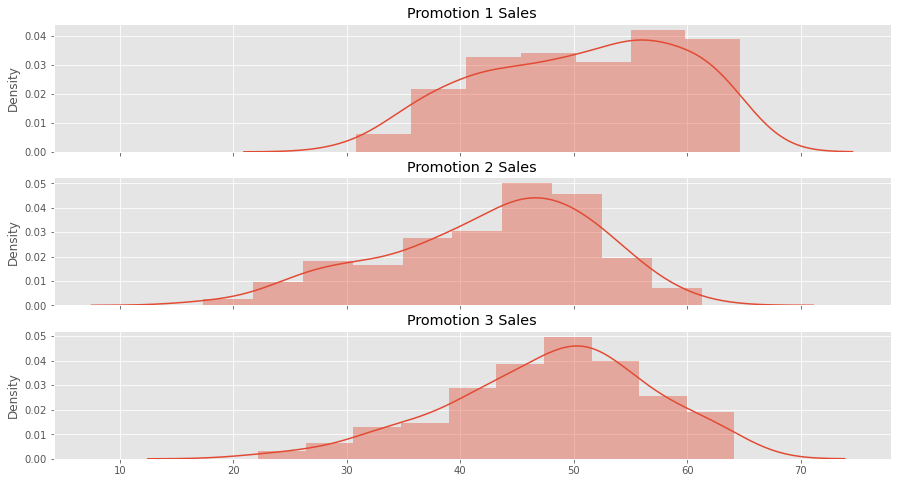

In [17]:
fig,ax=plt.subplots(3,1,figsize=(15,8),sharex=True)

for i in [1,2,3]:
    sns.distplot(df.loc[(df['Promotion']==i) & (df['SalesInThousands']<=65),'SalesInThousands'],ax=ax[i-1])
    ax[i-1].set_title('Promotion {} Sales'.format(i))
    ax[i-1].set_xlabel ("")

**Checking distribution of >65 group**

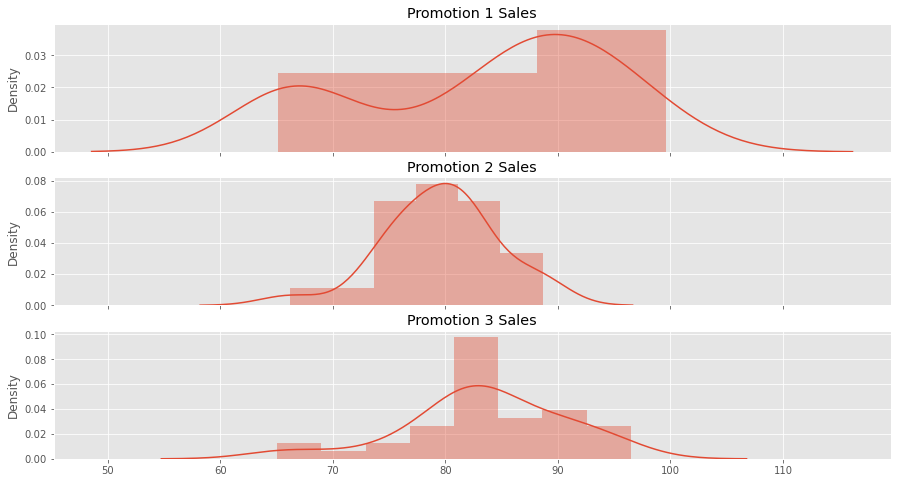

In [18]:
fig,ax=plt.subplots(3,1,figsize=(15,8),sharex=True)

for i in [1,2,3]:
    sns.distplot(df.loc[(df['Promotion']==i) & (df['SalesInThousands']>65),'SalesInThousands'],ax=ax[i-1])
    ax[i-1].set_title('Promotion {} Sales'.format(i))
    ax[i-1].set_xlabel ("")

#### Assumption Control

The common assumptions made when doing a t-test include normality of data distribution and equality of variance in standard deviation.

1. Normality of data distribution
2. Equality of variances

#### Normality Test for <=65 group

H0: The data is normally distributed

H1: The data is not normally distributed


In [19]:
from scipy.stats import shapiro
print ("Promotion 1 & <= 65: {}".format(shapiro(df.loc[(df['Promotion'] == 1) & (df['SalesInThousands']<=65), 'SalesInThousands'])))
print ("Promotion 2 & <= 65: {}".format(shapiro(df.loc[(df['Promotion'] == 2) & (df['SalesInThousands']<=65), 'SalesInThousands'])))
print ("Promotion 3 & <= 65: {}".format(shapiro(df.loc[(df['Promotion'] == 3) & (df['SalesInThousands']<=65), 'SalesInThousands'])))

Promotion 1 & <= 65: ShapiroResult(statistic=0.958892285823822, pvalue=0.0004932560259476304)
Promotion 2 & <= 65: ShapiroResult(statistic=0.9712842702865601, pvalue=0.0017379027558490634)
Promotion 3 & <= 65: ShapiroResult(statistic=0.9813416600227356, pvalue=0.04059775173664093)


###### All 3 groups pass normality test

#### Normality Test for >65 group

H0: The data is normally distributed

H1: The data is not normally distributed


In [20]:
from scipy.stats import shapiro
print ("Promotion 1 & > 65: {}".format(shapiro(df.loc[(df['Promotion'] == 1) & (df['SalesInThousands']>65), 'SalesInThousands'])))
print ("Promotion 2 & > 65: {}".format(shapiro(df.loc[(df['Promotion'] == 2) & (df['SalesInThousands']>65), 'SalesInThousands'])))
print ("Promotion 3 & > 65: {}".format(shapiro(df.loc[(df['Promotion'] == 3) & (df['SalesInThousands']>65), 'SalesInThousands'])))

Promotion 1 & > 65: ShapiroResult(statistic=0.8731706738471985, pvalue=0.0004092589661013335)
Promotion 2 & > 65: ShapiroResult(statistic=0.9646238088607788, pvalue=0.5380414724349976)
Promotion 3 & > 65: ShapiroResult(statistic=0.9593083262443542, pvalue=0.16909459233283997)


###### 2 groups fail normality test, so testing can't be done for these 3 groups

### Checking Same Variance Assumption

H0: The variances are equal(homogenous)

H1: The variances are unequal(non-homogenous)

In [21]:
#promo 1 & promo 2 
stats.levene(df.loc[(df['Promotion'] == 1) & (df['SalesInThousands']<=65),'SalesInThousands'], df.loc[(df['Promotion'] == 2) & (df['SalesInThousands']<=65), 'SalesInThousands'])

LeveneResult(statistic=0.08101138968625114, pvalue=0.776131155039429)

**Promo 1 & 2 have diff variances, so will do unequal variances t-test for them**

In [22]:
#promo 1 & promo 3 
stats.levene(df.loc[(df['Promotion'] == 1) & (df['SalesInThousands']<=65),'SalesInThousands'], df.loc[(df['Promotion'] == 3) & (df['SalesInThousands']<=65), 'SalesInThousands'])

LeveneResult(statistic=0.6698505571326162, pvalue=0.41379969879676226)

**Promo 1 & 3 have diff variances, so will do unequal variances t-test for them**

## A/B Testing for <=65 group

#### Comparing Promotion 1 vs Promotion 2

In [23]:
t, p= stats.ttest_ind(df.loc[(df['Promotion'] == 1) & (df['SalesInThousands']<=65), 'SalesInThousands'], 
    df.loc[(df['Promotion'] == 2) & (df['SalesInThousands']<=65), 'SalesInThousands'], 
    equal_var=False)
print("t-value = " +str(t))
print("p-value = " +str(p))

t-value = 7.824776742399254
p-value = 9.879819174248633e-14


In [24]:
df[df["SalesInThousands"]<=65].groupby('Promotion')['SalesInThousands'].mean()

Promotion
1    50.744361
2    42.608049
3    47.983691
Name: SalesInThousands, dtype: float64

**P<0.05 thus statistically significant difference in sales of Promo 1 & 2, promo 1 should be preferred**

#### Comparing Promotion 1 vs Promotion 3

In [25]:
t, p= stats.ttest_ind(df.loc[(df['Promotion'] == 1) & (df['SalesInThousands']<=65), 'SalesInThousands'], 
    df.loc[(df['Promotion'] == 3) & (df['SalesInThousands']<=65), 'SalesInThousands'], 
    equal_var=False)
print("t-value = " +str(t))
print("p-value = " +str(p))

t-value = 2.6332470611279164
p-value = 0.008932765144586902


**P<0.05 thus statistically significant difference in sales of Promo 1 & 3, promo 1 should be preferred**

#### Comparing Promotion 2 vs Promotion 3

In [26]:
t, p= stats.ttest_ind(df.loc[(df['Promotion'] == 2) & (df['SalesInThousands']<=65), 'SalesInThousands'], 
    df.loc[(df['Promotion'] == 3) & (df['SalesInThousands']<=65), 'SalesInThousands'], 
    equal_var=False)
print("t-value = " +str(t))
print("p-value = " +str(p))

t-value = -5.308277452910551
p-value = 2.114606026499446e-07


In [27]:
df[df["SalesInThousands"]<=65].groupby('Promotion')['SalesInThousands'].mean()

Promotion
1    50.744361
2    42.608049
3    47.983691
Name: SalesInThousands, dtype: float64

**P<0.05 thus statistically significant difference in sales of Promo 2 & 3, promo 3 should be preferred**

### Conclusion

***Of all 3 promotions 1st is the best one and 2nd should be stopped & replaced with 1 or 3. Out of 1 or 3 depending on the cost of promotion selection can be made, if promo 1 & 3 cost same then 1 is the way to go and if the cost of 1 is so high that it removes the gains from extra sales then promo 3 is to be used.***